# Clustering Retail RFM Data With K means

Import Required Libraries.

In [4]:
import pandas as pd
import numpy as np
import mysql.connector
import matplotlib as m
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import configparser

Connect to local mysql database and read retail rfm data into a pandas dataframe, df.

In [5]:
#get login credentials to connect to database from a config file
config = configparser.ConfigParser()
config.read('nb.cfg')

try:
    #connect to database
    connection = mysql.connector.connect(host=config['mysql']['host'], database=config['mysql']['database'],\
                                         user=config['mysql']['user'], password=config['mysql']['password'])

    get_data = """
                SELECT customerid, recency, frequency, monetary FROM consumer_rfm;
            """

    #create a copy of our dataset
    rfm = pd.read_sql(get_data, connection)

    connection.close()

except Exception as e:
    connection.close()
    print(str(e))

print(rfm.head())

   customerid  recency  frequency  monetary
0       12346      326          1  77183.60
1       12347        3          7   4310.00
2       12348       76          4   1797.24
3       12349       19          1   1757.55
4       12350      311          1    334.40


Display a summary of the data in rfm.

In [6]:
print(rfm.describe())

         customerid      recency    frequency       monetary
count   4339.000000  4339.000000  4339.000000    4339.000000
mean   15299.936852    93.041484     4.271952    2053.793017
std     1721.889758   100.007757     7.705493    8988.248381
min    12346.000000     1.000000     1.000000       0.000000
25%    13812.500000    18.000000     1.000000     307.245000
50%    15299.000000    51.000000     2.000000     674.450000
75%    16778.500000   142.500000     5.000000    1661.640000
max    18287.000000   374.000000   210.000000  280206.020000


Display box plot of columns of rfm (recency, frequency, monetary). And create histograms to display recency, frequency and monetary data.

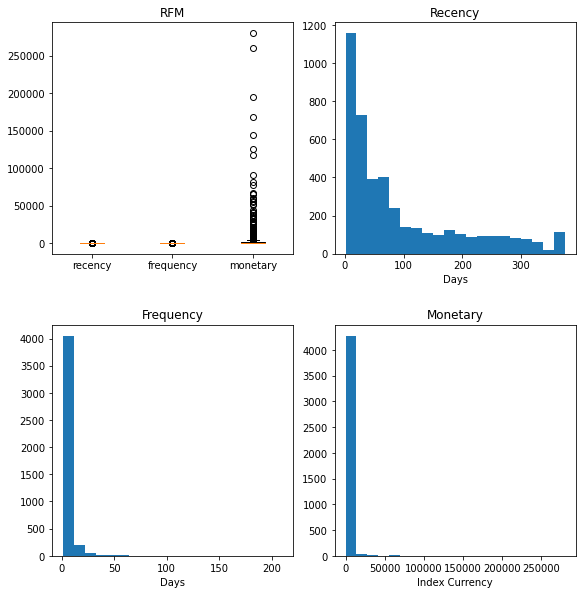

In [7]:
fig, axis = plt.subplots(2, 2, figsize=(8, 8))
fig.tight_layout(h_pad=5)

axis[0, 0].boxplot(rfm[rfm.columns[1:]], labels=["recency", "frequency", "monetary"])
axis[0, 0].set_title("RFM")
axis[0, 1].hist(rfm['recency'], bins=20)
axis[0, 1].set_title("Recency")
axis[0, 1].set_xlabel("Days")
axis[1, 0].hist(rfm['frequency'], bins=20)
axis[1, 0].set_title("Frequency")
axis[1, 0].set_xlabel("Days")
axis[1, 1].hist(rfm['monetary'], bins=20)
axis[1, 1].set_title("Monetary")
axis[1, 1].set_xlabel("Index Currency")

plt.show()

We see that recency, frequency, and monetary data are all very much right skewed. We attempt to remedy this slightly by removing outliers according to Tukey's rule, transforming, and then standardizing the data.

Make dataframe of 0.25, 0.5, and 0.75 quantiles of each column in rfm. Make dataframe of IQR for each column in rfm.
Make a dataframe to store the upper and lower bounds for recognizing outliers according to Tukey's rule.

In [8]:
#get quantiles
quantiles = rfm.loc[:,['recency', 'frequency', 'monetary']].quantile([0.25, 0.5, 0.75])

#compute IQR for each column
IQR = pd.DataFrame(columns=['recency', 'frequency', 'monetary'])
for col in IQR.columns:
    IQR[col] = [quantiles[col][0.75] - quantiles[col][0.25]]

#find bounds for recognizing outliers
outlier_bounds = pd.DataFrame(columns=['recency', 'frequency', 'monetary'])

for col in outlier_bounds:
    outlier_bounds.loc['upper', col] = quantiles[col][0.75] + 1.5*IQR[col][0]
    outlier_bounds.loc['lower', col] = quantiles[col][0.25] - 1.5*IQR[col][0]

print(quantiles, "\n")
print(IQR, "\n")
print(outlier_bounds)

      recency  frequency  monetary
0.25     18.0        1.0   307.245
0.50     51.0        2.0   674.450
0.75    142.5        5.0  1661.640 

   recency  frequency  monetary
0    124.5        4.0  1354.395 

      recency frequency   monetary
upper  329.25      11.0  3693.2325
lower -168.75      -5.0 -1724.3475


Get dataframe that contains the non outliers from rfm.

In [9]:
trimmed_rfm = rfm.loc[(rfm['recency'] <= outlier_bounds['recency']['upper']) & (rfm['recency'] >= outlier_bounds['recency']['lower'])\
        & (rfm['frequency'] <= outlier_bounds['frequency']['upper']) & (rfm['frequency'] >= outlier_bounds['frequency']['lower'])\
            & (rfm['monetary'] <= outlier_bounds['monetary']['upper']) & (rfm['monetary'] >= outlier_bounds['monetary']['lower']),\
                ['recency', 'frequency', 'monetary']]

Copy data from trimmed_rfm into a new dataframe and transform using a square root transformation, then apply standardization.

In [10]:
#make a new dataframe to store the scaled data
scaled_rfm = trimmed_rfm.loc[:, trimmed_rfm.columns]

#apply log transform
for col in scaled_rfm.columns:
    scaled_rfm[col] = np.power(scaled_rfm[col], 0.5)

#scale 
scaler = StandardScaler()
scaler.fit(scaled_rfm)
scaled = scaler.transform(scaled_rfm)
scaled_rfm = pd.DataFrame(scaled, columns=scaled_rfm.columns)

Produce box plots and histograms for the transformed data.

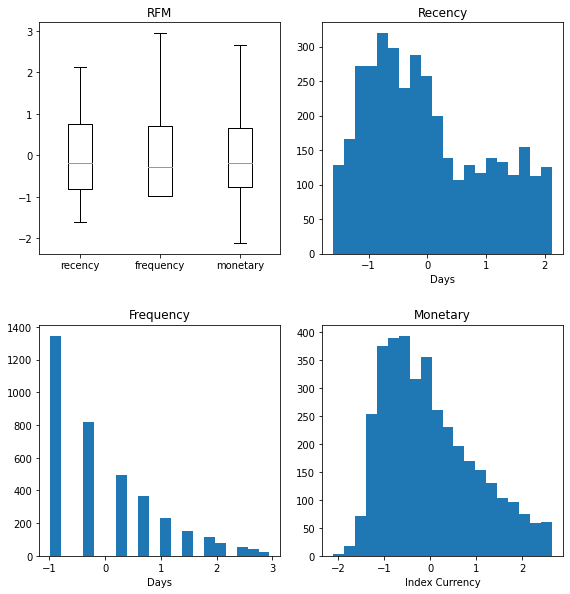

In [11]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.tight_layout(h_pad=5)

axis[0, 0].boxplot(scaled_rfm[trimmed_rfm.columns], labels=["recency", "frequency", "monetary"])
axis[0, 0].set_title("RFM")
axis[0, 1].hist(scaled_rfm['recency'], bins=20)
axis[0, 1].set_title("Recency")
axis[0, 1].set_xlabel("Days")
axis[1, 0].hist(scaled_rfm['frequency'], bins=20)
axis[1, 0].set_title("Frequency")
axis[1, 0].set_xlabel("Days")
axis[1, 1].hist(scaled_rfm['monetary'], bins=20)
axis[1, 1].set_title("Monetary")
axis[1, 1].set_xlabel('Index Currency')

plt.show()

Recency, Frequency, and Monetary data have become less right-skewed after transformation. They are, however, still right-skewed, especially Frequency. 

To choose the number of clusters for the k-means algorithm an elbow chart of k-means inertia is used.

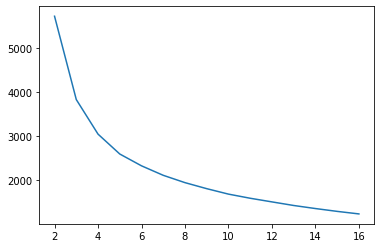

In [12]:
#elbo chart method to choose parameters
error = []
n_means = [i + 2 for i in range(15)]
for n in n_means:
    #initialize KMeans object and fit data
    kmeans = KMeans(n_clusters = n)
    kmeans.fit(scaled_rfm)
    error.append(kmeans.inertia_)

#elbo plot
plt.plot(n_means, error)
plt.show()

5 looks like a good number of cluster.

Fit k-means to scaled_rfm.

In [13]:
#fit model
kmeans = KMeans(n_clusters=5)
kmeans.fit(scaled_rfm)
#get cluster labels
scaled_rfm['km_cluster'] = kmeans.labels_
trimmed_rfm['km_cluster'] = kmeans.labels_

Save retail data with cluster labels to a CSV file.

In [14]:
trimmed_rfm.to_csv(r"C:\temp\retail_rfm_clusters.csv") #this is just the file path that I saved to on my computer

Print inertia from this model.

In [15]:
print(kmeans.inertia_)

2596.6888255947756


Create boxplots of for each cluster in recency, frequency and monetary.

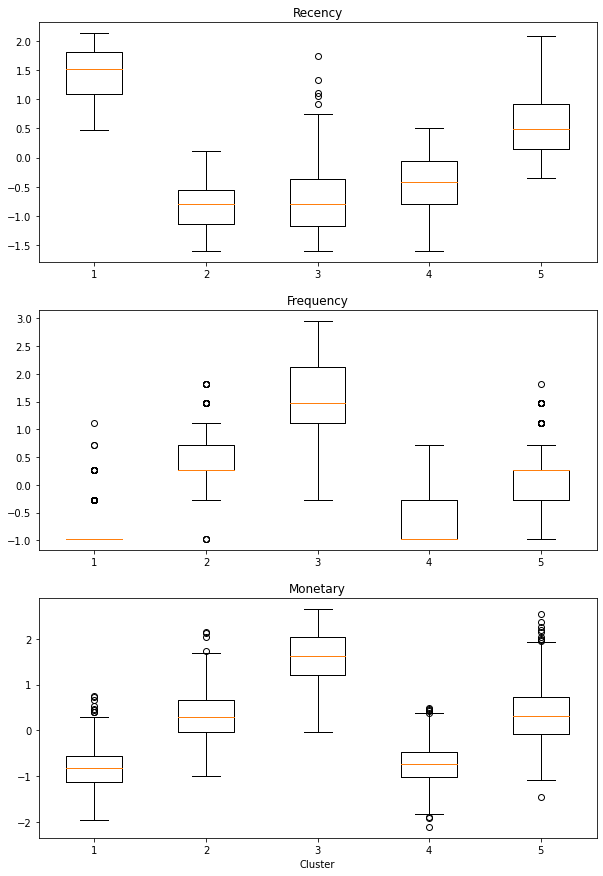

In [16]:
figure, axis = plt.subplots(3, figsize=(10,15))
fig.tight_layout(h_pad=20)

axis[0].boxplot([scaled_rfm.loc[scaled_rfm['km_cluster'] == i]['recency'] for i in range(5)])
axis[0].set_title('Recency')
axis[1].boxplot([scaled_rfm.loc[scaled_rfm['km_cluster'] == i]['frequency'] for i in range(5)])
axis[1].set_title('Frequency')
axis[2].boxplot([scaled_rfm.loc[scaled_rfm['km_cluster'] == i]['monetary'] for i in range(5)])
axis[2].set_title('Monetary')
axis[2].set_xlabel('Cluster')

plt.show()

Initialize a colour map to use to colour scatter plots of the clustered data.

In [17]:
colourmap = ['red', 'blue', 'orange', 'purple', 'lime', 'teal', 'aquamarine', 'magenta']

Display scatter plots of each pair of recency, frequency, and monetary before transforming and scaling, coloured by cluster.

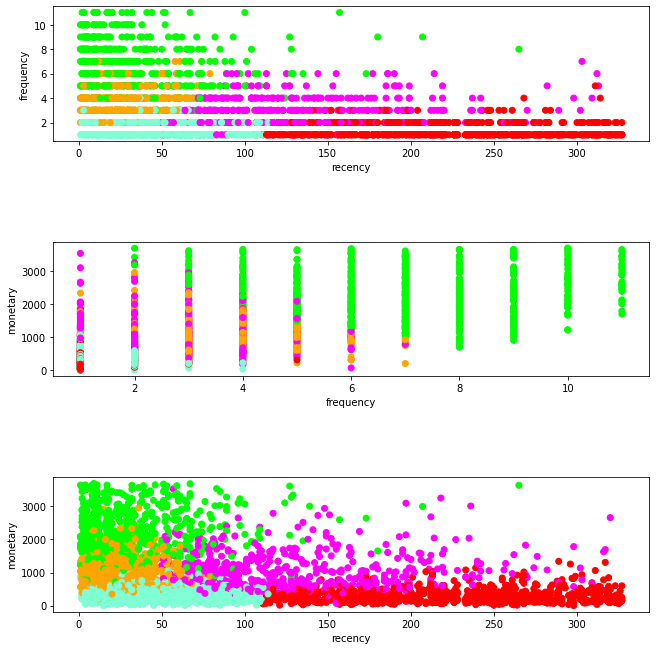

In [18]:
fig, axis = plt.subplots(3, figsize=(9, 9))
fig.tight_layout(h_pad=8)

axis[0].scatter(trimmed_rfm['recency'], trimmed_rfm['frequency'], \
    c=trimmed_rfm['km_cluster'], cmap=m.colors.ListedColormap(colourmap))
axis[0].set_xlabel('recency')
axis[0].set_ylabel('frequency')

axis[1].scatter(trimmed_rfm['frequency'], trimmed_rfm['monetary'], \
    c=trimmed_rfm['km_cluster'], cmap=m.colors.ListedColormap(colourmap))
axis[1].set_xlabel('frequency')
axis[1].set_ylabel('monetary')

axis[2].scatter(trimmed_rfm['recency'], trimmed_rfm['monetary'], \
    c=trimmed_rfm['km_cluster'], cmap=m.colors.ListedColormap(colourmap))
axis[2].set_xlabel('recency')
axis[2].set_ylabel('monetary')

plt.show()

Display a 3d scatter plot of recency, frequency, and monetary before transforming and scaling, coloured by cluster.

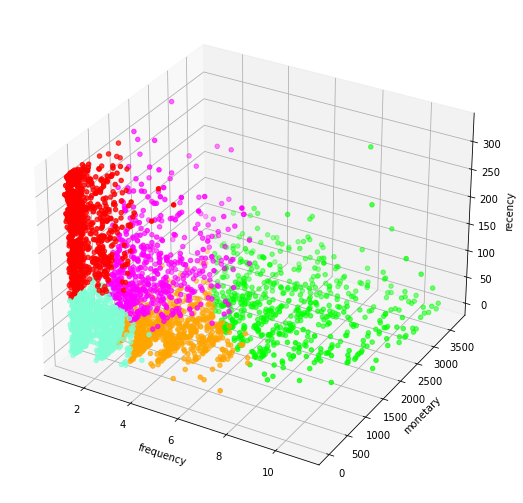

In [19]:
fig = plt.figure(3, figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(trimmed_rfm['frequency'], trimmed_rfm['monetary'], trimmed_rfm['recency'], \
    c=trimmed_rfm['km_cluster'], cmap=m.colors.ListedColormap(colourmap))
ax.set_xlabel('frequency')
ax.set_ylabel('monetary')
ax.set_zlabel('recency')
plt.show()